# Gate Cutting to Reduce Circuit Depth

In this tutorial, we will reduce a circuit's depth by cutting distant gates, avoiding the swap gates that would otherwise be introduced by routing.

These are the steps that we will take in this [Qiskit pattern](https://docs.quantum.ibm.com/guides/intro-to-patterns):

- **Step 1: Map problem to quantum circuits and operators**:
    - Map the hamiltonian onto a quantum circuit.
- **Step 2: Optimize for target hardware** [_Uses the cutting addon_]:
    - <font color='#0F62FE'>Cut the circuit and observable.</font>
    - Transpile the subexperiments for hardware.
- **Step 3: Execute on target hardware**:
    - Run the subexperiments obtained in Step 2 using a `Sampler` primitive.
- **Step 4: Post-process results** [_Uses the cutting addon_]:
    - <font color='#0F62FE'>Combine the results of Step 3 to reconstruct the expectation value of the observable in question.</font>

## Step 1: Map

### Create a circuit to run on the backend

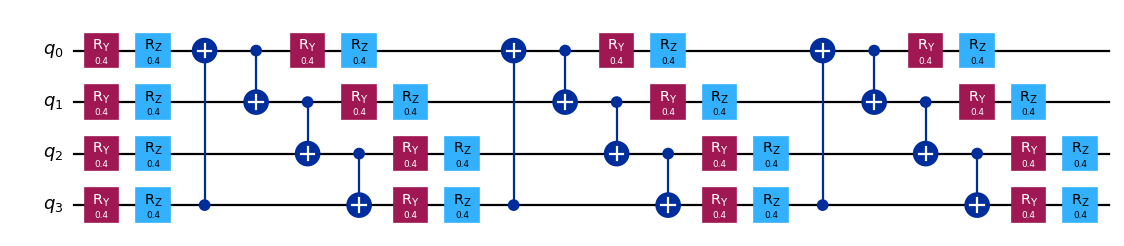

In [1]:
from qiskit.circuit.library import efficient_su2

circuit = efficient_su2(num_qubits=4, entanglement="circular")
circuit.assign_parameters([0.4] * len(circuit.parameters), inplace=True)
circuit.draw("mpl", scale=0.8)

### Specify an observable

In [2]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp(["ZZII", "IZZI", "-IIZZ", "XIXI", "ZIZZ", "IXIX"])

## Step 2: Optimize

### Specify a backend

You can provide either a fake backend or a hardware backend from Qiskit Runtime.

In [3]:
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

backend = FakeManilaV2()

### Transpile the circuit, visualize the swaps, and note the depth

We choose a layout that requires two swaps to execute the gates between qubits 3 and 0 and another two swaps to return the qubits to their initial positions.

In [4]:
from qiskit.transpiler import generate_preset_pass_manager

pass_manager = generate_preset_pass_manager(
    optimization_level=1, backend=backend, initial_layout=[0, 1, 2, 3]
)

transpiled_qc = pass_manager.run(circuit)
print(f"Transpiled circuit depth: {transpiled_qc.depth(lambda x: len(x[1]) >= 2)}")

Transpiled circuit depth: 30


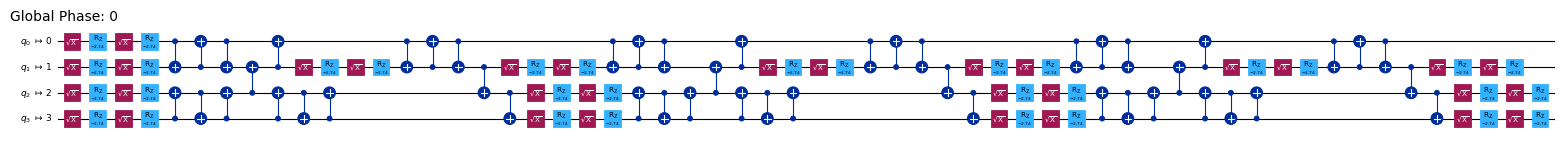

In [5]:
transpiled_qc.draw("mpl", scale=0.4, idle_wires=False, fold=-1)

### Replace distant gates with `TwoQubitQPDGate`s by specifying their indices

`cut_gates` will replace the gates in the specified indices with `TwoQubitQPDGate`s and also return a list of `QPDBasis` instances -- one for each gate decomposition.

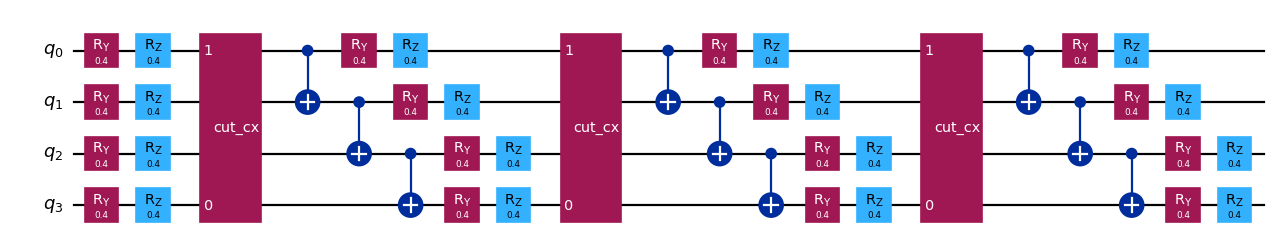

In [6]:
from qiskit_addon_cutting import cut_gates

# Find the indices of the distant gates
cut_indices = [
    i
    for i, instruction in enumerate(circuit.data)
    if {circuit.find_bit(q)[0] for q in instruction.qubits} == {0, 3}
]

# Decompose distant CNOTs into TwoQubitQPDGate instances
qpd_circuit, bases = cut_gates(circuit, cut_indices)

qpd_circuit.draw("mpl", scale=0.8)

### Generate the subexperiments to run on the backend

`generate_cutting_experiments` accepts a circuit containing `TwoQubitQPDGate` instances and observables as a `PauliList`.

To simulate the expectation value of the full-sized circuit, many subexperiments are generated from the decomposed gates' joint quasiprobability distribution and then executed on one or more backends. The number of samples taken from the distribution is controlled by `num_samples`, and one combined coefficient is given for each unique sample. For more information on how the coefficients are calculated, refer to the [explanatory material](../explanation/index.rst).

**Note:** The ``observables`` kwarg to `generate_cutting_experiments` is of type `PauliList`. Observable term coefficients and phases are ignored during decomposition of the problem and execution of the subexperiments. They may be re-applied during reconstruction of the expectation value.

In [7]:
import numpy as np
from qiskit_addon_cutting import generate_cutting_experiments

# Generate the subexperiments and sampling coefficients
subexperiments, coefficients = generate_cutting_experiments(
    circuits=qpd_circuit, observables=observable.paulis, num_samples=np.inf
)

### Calculate the sampling overhead for the chosen cuts

Here we cut three CNOT gates, resulting in a sampling overhead of $9^3$.

For more on the sampling overhead incurred by circuit cutting, refer to the [explanatory material](../explanation/index.rst).

In [8]:
print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")

Sampling overhead: 729.0


### Demonstrate that the QPD subexperiments will be shallower after cutting distant gates

Here is an example of an arbitrarily chosen subexperiment generated from the QPD circuit. Its depth has been reduced by more than half. Many of these probabilistic subexperiments must be generated and evaluated in order to reconstruct an expectation value of the deeper circuit.

Original circuit depth after transpile: 30
QPD subexperiment depth after transpile: 7


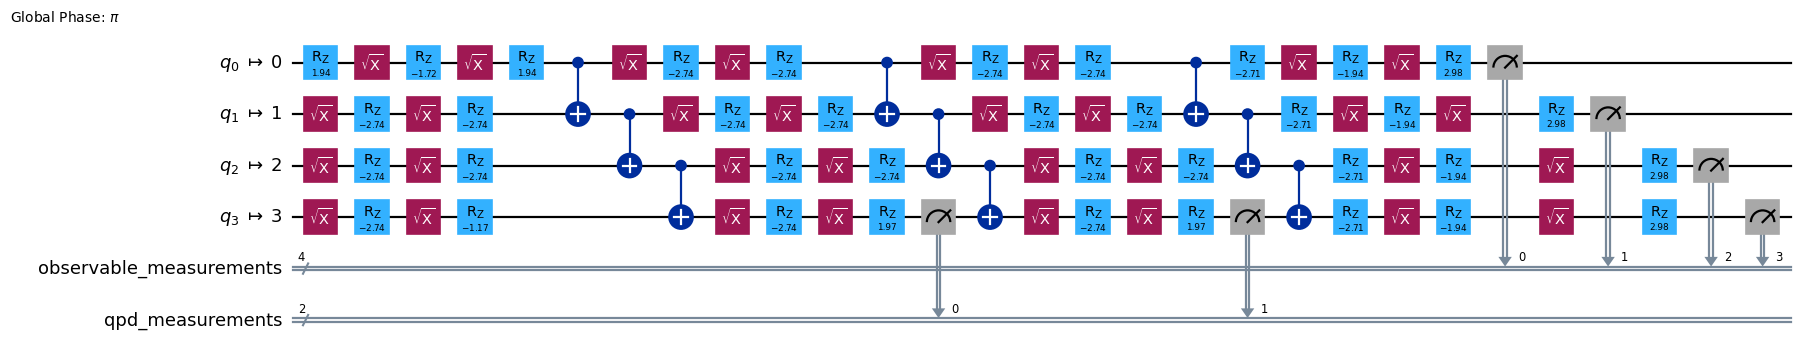

In [9]:
# Transpile the decomposed circuit to the same layout
transpiled_qpd_circuit = pass_manager.run(subexperiments[100])

print(
    f"Original circuit depth after transpile: {transpiled_qc.depth(lambda x: len(x[1]) >= 2)}"
)
print(
    f"QPD subexperiment depth after transpile: {transpiled_qpd_circuit.depth(lambda x: len(x[1]) >= 2)}"
)
transpiled_qpd_circuit.draw("mpl", scale=0.8, idle_wires=False, fold=-1)

### Prepare subexperiments for the backend

In [ ]:
# Transpile the subeperiments to the backend's instruction set architecture (ISA)
isa_subexperiments = pass_manager.run(subexperiments)

## Step 3: Execute

### Run the subexperiments using the Qiskit Runtime Sampler primitive

In [ ]:
from qiskit_ibm_runtime import SamplerV2

# Set up the Qiskit Runtime Sampler primitive.  For a fake backend, this will use a local simulator.
sampler = SamplerV2(backend)

# Submit the subexperiments
job = sampler.run(isa_subexperiments)

In [ ]:
# Retrieve the results
results = job.result()

## Step 4: Post-process

### Reconstruct the expectation value

Reconstruct expectation values for each observable term and combine them to reconstruct the expectation value for the original observable.

In [11]:
from qiskit_addon_cutting import reconstruct_expectation_values

reconstructed_expval_terms = reconstruct_expectation_values(
    results,
    coefficients,
    observable.paulis,
)
# Reconstruct final expectation value
reconstructed_expval = np.dot(reconstructed_expval_terms, observable.coeffs)

### Compare the reconstructed expectation value with the exact expectation value from the original circuit and observable

In [12]:
from qiskit_aer.primitives import EstimatorV2

estimator = EstimatorV2()
exact_expval = estimator.run([(circuit, observable)]).result()[0].data.evs
print(f"Reconstructed expectation value: {np.real(np.round(reconstructed_expval, 8))}")
print(f"Exact expectation value: {np.round(exact_expval, 8)}")
print(f"Error in estimation: {np.real(np.round(reconstructed_expval-exact_expval, 8))}")
print(
    f"Relative error in estimation: {np.real(np.round((reconstructed_expval-exact_expval) / exact_expval, 8))}"
)

Reconstructed expectation value: 0.80566406
Exact expectation value: 0.50497603
Error in estimation: 0.30068803
Relative error in estimation: 0.5954501
